In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import matplotlib.cm as cm
import datetime 
import time
from scipy.fft import fft, ifft, fftshift
from scipy.fftpack import fftfreq
from EOF import EOF
import gc

In [3]:
import numpy as np
import h5py
from multiprocessing import Pool
from Zonal_Calculation import Zonal_Calculation
import time
from multiprocessing import Pool


# 1014 calculate prime

In [11]:
PR = 10
start_day = 500
end_day   = 525
for day in range(start_day, end_day, 25):
    file_path  = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}/RH80_PR{PR}_20000day_startfrom_{day}day_final.dat"

    u_zonal_calc  = Zonal_Calculation(3, "grid_u_c_xyzt")
    u             = u_zonal_calc.load_data(file_path)
    u_prime       = u_zonal_calc.zonal_anomaly(u)

    v_zonal_calc  = Zonal_Calculation(3, "grid_v_c_xyzt")
    v             = v_zonal_calc.load_data(file_path)
    v_prime       = v_zonal_calc.zonal_anomaly(v)

    del u, v, u_prime, v_prime
    gc.collect()
    





(20.0, 0.0)

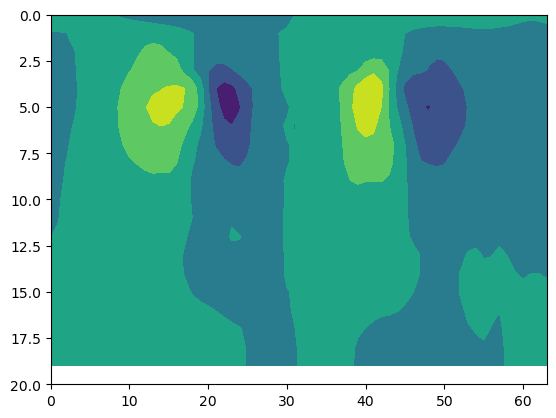

In [12]:
plt.figure()
plt.contourf((u_prime * v_prime).mean(axis=(0,3)))
plt.ylim([20,0])

# Old things

In [1]:
# def calculate_prec(qv_diff, p_half):
#     g = 9.81
#     Prec = np.zeros(qv_diff.shape)
#     for i in range(1, 20 - 1):
#         Prec[:, i, :, :] = 1 / g * qv_diff[:, i, :, :] * (p_half[:, i + 1, :, :] - p_half[:, i, :, :])
#     Prec[:, 0, :, :] = 1 / g * qv_diff[:, 0, :, :] * (p_half[:, 1, :, :] - p_half[:, 0, :, :])
#     Prec_mean = np.nansum(Prec[:,:6,:,:], axis=(1)) # (time, y, x)
#     # Prec_mean_y = np.nanmean(Prec_mean, axis=(0, 2))
#     return Prec_mean

# def calculate_prec_chunk(qv_diff_chunk, p_half_chunk):
#     g = 9.81
#     Prec_chunk = np.zeros(qv_diff_chunk.shape)
#     for i in range(1, 20 - 1):
#         Prec_chunk[:, i, :, :] = 1 / g * qv_diff_chunk[:, i, :, :] * (p_half_chunk[:, i + 1, :, :] - p_half_chunk[:, i, :, :])
#     Prec_chunk[:, 0, :, :] = 1 / g * qv_diff_chunk[:, 0, :, :] * (p_half_chunk[:, 1, :, :] - p_half_chunk[:, 0, :, :])
#     Prec_mean_chunk = np.nansum(Prec_chunk[:, :12, :, :], axis=1)  # (time, y, x)
#     return Prec_mean_chunk

In [2]:
# def process_pr(PR):
#     print(f"Processing PR={PR}")
#     qv_diff_file_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/qv_diff/PR{PR}_500_20000day_6hourly_qv_diff.dat"
#     p_half_file_path  = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF" + f"/PR{PR}/p_half/PR{PR}_500_20000day_6hourly_p_half.dat"

#     print(f"PR={PR}, ---1---")
#     with h5py.File(qv_diff_file_path, 'r') as file:
#         qv_diff = np.asarray(file['qv_diff'][:, :, :, :])
        
#     print(f"PR={PR}, ---2---")
#     with h5py.File(p_half_file_path, 'r') as file:
#         p_half = np.asarray(file['p_half'][:, :, :, :])

#     print(f"PR={PR}, ---3---")
#     prec = calculate_prec(qv_diff, p_half)
#     save_to_hdf5(prec, "prec", common_path + f"/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_300hPa_sum.dat") # (time, y, x)
#     gc.collect()
#     print(f"PR={PR}, ---4---")
    
# def process_pr_with_chunk(PR, chunk_size=1000):
#     print(f"Processing PR={PR}")
#     qv_diff_file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/qv_diff/PR{PR}_500_20000day_6hourly_qv_diff.dat"
#     p_half_file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/p_half/PR{PR}_500_20000day_6hourly_p_half.dat"

#     print(f"PR={PR}, ---1---")
#     with h5py.File(qv_diff_file_path, 'r') as qv_diff_file, h5py.File(p_half_file_path, 'r') as p_half_file:
#         qv_diff = qv_diff_file['qv_diff']
#         p_half = p_half_file['p_half']
        
#         time_len = qv_diff.shape[0]  # Assuming time is the first dimension
#         prec_total = np.zeros((time_len, qv_diff.shape[2], qv_diff.shape[3]))  # For storing total precipitation
        
#         for start in range(0, time_len, chunk_size):
#             end = min(start + chunk_size, time_len)
#             print(f"Processing chunk {start} to {end} for PR={PR}")
            
#             # Load the chunk
#             qv_diff_chunk = qv_diff[start:end, :, :, :]
#             p_half_chunk = p_half[start:end, :, :, :]
            
#             # Process the chunk
#             prec_chunk = calculate_prec_chunk(qv_diff_chunk, p_half_chunk)
#             prec_total[start:end, :, :] = prec_chunk
            
#             # Free memory
#             del qv_diff_chunk, p_half_chunk, prec_chunk
#             gc.collect()

#     save_to_hdf5(prec_total, "prec", f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_300hPa_sum.dat")
#     print(f"PR={PR}, ---4---")

In [ ]:
# def save_to_hdf5(data, data_name, file_path):
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)

# if __name__ == "__main__":
#     PR_values = [0, 10, 20, 30, 40, 50]
#     chunk_size = 1000  # You can adjust this based on memory availability
#     with Pool(processes=6) as pool:
#         pool.starmap(process_pr_with_chunk, [(PR, chunk_size) for PR in PR_values])
#     print("All processes completed")

Processing PR=10Processing PR=40Processing PR=20Processing PR=50Processing PR=30Processing PR=0





PR=10, ---1---PR=40, ---1---PR=30, ---1---PR=20, ---1---PR=50, ---1---PR=0, ---1---







In [ ]:
# import numpy as np
# import h5py
# import gc
# import time
# from multiprocessing import Pool

# def calculate_prec(qv_diff, p_half):
#     """Calculate precipitation from specific humidity difference and half-level pressures."""
#     g = 9.81
#     Prec = np.zeros(qv_diff.shape)
#     for i in range(1, 20 - 1):
#         Prec[:, i, :, :] = 1 / g * qv_diff[:, i, :, :] * (p_half[:, i + 1, :, :] - p_half[:, i, :, :])
#     Prec[:, 0, :, :] = 1 / g * qv_diff[:, 0, :, :] * (p_half[:, 1, :, :] - p_half[:, 0, :, :])
#     Prec_mean = np.nansum(Prec, axis=(1))  # (time, y, x)
#     return Prec_mean

# def process_pr(PR):
#     """Process data for a specific PR value."""
#     print(f"Processing PR={PR}")
#     common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
#     qv_diff_file_path = f"{common_path}/PR{PR}/qv_diff/PR{PR}_500_20000day_6hourly_qv_diff.dat"
#     p_half_file_path = f"{common_path}/PR{PR}/p_half/PR{PR}_500_20000day_6hourly_p_half.dat"
#     prec_file_path = f"{common_path}/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat"

#     # Open HDF5 files once and process data in chunks
#     with h5py.File(qv_diff_file_path, 'r') as qv_diff_file, h5py.File(p_half_file_path, 'r') as p_half_file:
#         qv_diff_dataset = qv_diff_file['qv_diff']
#         p_half_dataset = p_half_file['p_half']
#         num_time_steps = qv_diff_dataset.shape[0]
#         chunk_size = 100  # Define chunk size to optimize memory usage

#         # Initialize array to store the results
#         prec_data = np.zeros((num_time_steps, 64, 128), dtype='f4')

#         # Process data in chunks
#         for start_idx in range(0, num_time_steps, chunk_size):
#             end_idx = min(start_idx + chunk_size, num_time_steps)

#             qv_diff_chunk = qv_diff_dataset[start_idx:end_idx, :, :, :]
#             p_half_chunk = p_half_dataset[start_idx:end_idx, :, :, :]

#             # Calculate precipitation for the current chunk
#             prec_chunk = calculate_prec(qv_diff_chunk, p_half_chunk)

#             # Save the processed chunk to the array
#             prec_data[start_idx:end_idx, :, :] = prec_chunk

#             # Clear memory
#             del qv_diff_chunk, p_half_chunk, prec_chunk
#             gc.collect()

#         # Save the entire dataset to an HDF5 file using your defined function
#         save_to_hdf5(prec_data, "prec", prec_file_path)

#     print(f"Completed processing for PR={PR}")

# def save_to_hdf5(data, data_name, file_path):
#     """Save data to an HDF5 file."""
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)

# if __name__ == "__main__":
#     PR_values = [0, 10, 20, 30, 40, 50]
#     start_time = time.time()
#     with Pool(processes=6) as pool:
#         pool.map(process_pr, PR_values)
#     print("All processes completed")
#     print(f"Total execution time: {time.time() - start_time:.2f} seconds")


# EP flux = - u'v' j + ${f_0 \over N^2} $\partial$ $\theta$ \over $\partial z$

In [ ]:
# # PR = 30 => startfrom 20000 day == final, it doesn't exit xyzt, which is missing
# # Constants
# # PR = 30

# # Saving b and v'b'
# for PR in [0,10,30,50]:
#     print("PR=", PR)
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x
    
#     # Pre-allocate the entire array
#     # u_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     v_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     theta_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     theta_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     b_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    
#     # Initialize Zonal_Calculation object once if all files have the same structure
#     t_zonal_calc  = Zonal_Calculation(3, "grid_t_c_xyzt")
#     p_zonal_calc  = Zonal_Calculation(3, "grid_p_full_xyzt")
#     ps_zonal_calc = Zonal_Calculation(3, "grid_ps_c_xyzt")
#     print("---1---")
    
#     u_zonal_calc  = Zonal_Calculation(3, "grid_u_c_xyzt")
#     v_zonal_calc  = Zonal_Calculation(3, "grid_v_c_xyzt")
    
    
#     Rd = 287
#     cp = 1004
#     g  = 9.81
#     # Process each day
#     for i, start in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start}day_final.dat"    
#         t_data  = t_zonal_calc.load_data(file_path)
#         p_data  = p_zonal_calc.load_data(file_path)
#         ps_data = ps_zonal_calc.load_data(file_path)
#         # u_data = u_zonal_calc.load_data(file_path)
#         v_data = v_zonal_calc.load_data(file_path)

#         # Cal prime, theta_prime can't be used by class because Dycore dosen't output grid_theta_xyzt
#         # u_prime     = u_zonal_calc.zonal_anomaly(u_data)   # FIXED!!!!!! 8/4 u_prime     = v_zonal_calc.zonal_anomaly(v_data)
#         v_prime     = v_zonal_calc.zonal_anomaly(v_data)  
        
#         theta       = t_data * (ps_data / p_data)**(Rd/cp)
#         theta_prime = theta - theta.mean(axis=3)[:,:,:,np.newaxis] # FIXED!!! Origin:theta_prime = t_zonal_calc.zonal_anomaly(theta) # 
        
#         # Insert data into the pre-allocated array
#         # u_prime_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = u_prime
#         v_prime_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = v_prime
#         theta_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :]   = theta
#         theta_prime_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :]   = theta_prime
        
#         # Optional progress logging
#         if start % 1000 == 0:
#             print(f"Processed day {start}")
    
#     print("done")
#     del t_data, ps_data, p_data

#     # Saving
#     # u_prime
#     # u_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u_prime/PR{PR}_500_20000day_6hourly_u_prime.dat"  
#     # with h5py.File(u_prime_file, 'w') as u_prime_file0:
#     #     u_prime_file0.create_dataset('u_prime',data=u_prime_final)
#     # del u_prime_final
#     # print("---7---")
    
#     # # v_prime
#     # v_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v_prime/PR{PR}_500_20000day_6hourly_v_prime.dat"  
#     # with h5py.File(v_prime_file, 'w') as v_prime_file0:
#     #     v_prime_file0.create_dataset('v_prime',data=v_prime_final)
#     # del v_prime_final
#     # print("---8---")

#     # # theta
#     # theta_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta.dat"  
#     # with h5py.File(theta_file, 'w') as theta_file0:
#     #     theta_file0.create_dataset('theta',data=theta_final)
#     # del theta_final
#     # print("---9---")
    
#     # # theta_prime
#     # theta_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/theta_prime/PR{PR}_500_20000day_6hourly_theta_prime.dat"  
#     # with h5py.File(theta_prime_file, 'w') as theta_prime_file0:
#     #     theta_prime_file0.create_dataset('theta_prime',data=theta_prime_final)
#     # del theta_prime_final
#     # print("---10---")

#     # b_prime
#     b_prime = theta_prime_final / np.mean(theta_final, axis=3)[:,:,:,np.newaxis] * 9.81
#     b_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime.dat"
#     with h5py.File(b_prime_file, 'w') as file:
#         file.create_dataset('b_prime', data=b_prime)
#     del b_prime

#     # Read long time mean theta to calculate b_prime
#     # theta_long_time_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta.dat"
#     # theta_long_time_file_read = h5py.File(theta_long_time_file, "r")
#     # theta_long_time = np.asarray(theta_long_time_file_read['theta'][:,:,:,:])
#     # print("---5---")

#     # Read long time mean theta to calculate b_prime
#     # v_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v_prime/PR{PR}_500_20000day_6hourly_v_prime.dat"
#     # v_prime_file_read = h5py.File(v_prime_file, "r")
#     # v_prime = np.asarray(v_prime_file_read['v_prime'][:5000*4,:,:,:])
#     # print("---5---")
    
#     # v_prime_b_prime
#     vb_mean = np.mean(v_prime * b_prime, axis=(0,3))
#     del theta_prime_final, theta_final
#     print("---6---")

#     # Saving
#     vb_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v_prime_b_prime/PR{PR}_500_20000day_6hourly_v_prime_b_prime.dat"  
#     with h5py.File(vb_file, 'w') as vb_file0:
#         vb_file0.create_dataset('v_prime_b_prime',data=vb_mean)
#     del vb_mean
#     # print("---5---")
#     Original code
# def process_pr(PR):
#     print("Processing PR=", PR)
#     start = time.time()
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     # t_zonal_calc = Zonal_Calculation(3, "grid_t_c_xyzt")
#     p_zonal_calc = Zonal_Calculation(3, "grid_p_full_xyzt")
#     ps_zonal_calc = Zonal_Calculation(3, "grid_ps_c_xyzt")
#     # v_zonal_calc = Zonal_Calculation(3, "grid_v_c_xyzt")
#     # u_zonal_calc = Zonal_Calculation(3, "grid_u_c_xyzt")
#     print("---Initialized Zonal Calculators---")

#     # Memory-mapped arrays for large datasets
#     # u_prime_final = np.memmap('/tmp/u_prime_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     # v_prime_final = np.memmap('/tmp/v_prime_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     # theta_final = np.memmap('/tmp/theta_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     # theta_prime_final = np.memmap('/tmp/theta_prime_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     # 08/14 add output pressure, surface pressure, and sigma
#     p_final = np.memmap('/tmp/p_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     ps_final = np.memmap('/tmp/ps_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     sigma_final = np.memmap('/tmp/sigma_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     # add u_final
#     # u_final = np.memmap('/tmp/u_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))

#     Rd, cp, g = 287, 1004, 9.81  # Constants

#     # Process each day in chunks
#     chunk_size = 10  # Adjust chunk size as needed
#     for i, start in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start}day_final.dat"
        
#         # Process data in smaller chunks to reduce memory usage
#         for chunk_start in range(0, num_time_steps, chunk_size):
#             chunk_end = min(chunk_start + chunk_size, num_time_steps)

#             # t_data = t_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             p_data = p_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             ps_data = ps_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             # v_data = v_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             # u_data = u_zonal_calc.load_data(file_path)[chunk_start:chunk_end]

#             # u_prime = u_zonal_calc.zonal_anomaly(u_data)
#             # v_prime = v_zonal_calc.zonal_anomaly(v_data)
#             # theta = t_data * (ps_data / p_data)**(Rd/cp)
#             # theta_prime = theta - np.mean(theta, axis=3, keepdims=True)

#             # u_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = u_prime
#             # v_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = v_prime
#             # theta_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = theta
#             # theta_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = theta_prime
#             # 08/14 add output pressure, surface pressure, and sigma
#             p_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = p_data
#             ps_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = ps_data

#             # u_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = u_data

#             # Clear memory
#             # del u_prime, v_prime, theta, theta_prime
#             # del u_data
            
#             # 08/14 add
#             del p_data, ps_data
#             gc.collect()
            
#         if start % 1000 == 0:
#             print(f"Processed day {start}")
#         gc.collect()
        

#     # Compute and save b_prime
#     # theta_final_zonal_mean = np.mean(theta_final, axis=3, keepdims=True)
#     # theta_final_add_dims = np.empty_like(theta_final)
#     # theta_final_add_dims[:] = theta_final_zonal_mean

#     # b_prime = theta_prime_final / theta_final_add_dims * g
#     # Save data using memory-mapped arrays
#     common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
#     # save_to_hdf5(u_prime_final, "u_prime", common_path + f"/PR{PR}/u_prime/PR{PR}_500_20000day_6hourly_u_prime.dat")
#     # save_to_hdf5(v_prime_final, "v_prime", common_path + f"/PR{PR}/v_prime/PR{PR}_500_20000day_6hourly_v_prime.dat")
#     # save_to_hdf5(u_prime_final * v_prime_final, "EMF", common_path + f"/PR{PR}/EMF/PR{PR}_500_20000day_6hourly_EMF.dat")
#     # save_to_hdf5((u_prime_final * v_prime_final).mean(axis=3), "EMF", common_path + f"/PR{PR}/EMF/PR{PR}_500_20000day_6hourly_EMF_zonal_mean.dat")
#     # save_to_hdf5(theta_final, "theta", common_path + f"/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta.dat")
#     # save_to_hdf5(theta_prime_final, "theta_prime", common_path + f"/PR{PR}/theta_prime/PR{PR}_500_20000day_6hourly_theta_prime.dat")

#     # # Saving zonal mean var
#     # save_to_hdf5(theta_final.mean(axis=3), "theta", common_path + f"/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta_zonal_mean.dat")
    
#     # # Save b_prime and its zonal mean
#     # save_to_hdf5(b_prime, "b_prime", common_path + f"/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime.dat")
#     # save_to_hdf5(b_prime.mean(axis=3), "b_prime", common_path + f"/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime_zonal_mean.dat")

#     # save_to_hdf5(v_prime_final * b_prime, "v_prime_b_prime", common_path + f"/PR{PR}/v_prime_b_prime/PR{PR}_500_20000day_6hourly_v_prime_b_prime.dat")
#     # save_to_hdf5((v_prime_final * b_prime).mean(axis=3), "v_prime_b_prime", common_path + f"/PR{PR}/v_prime_b_prime/PR{PR}_500_20000day_6hourly_v_prime_b_prime_zonal_mean.dat")

#     # 08/14 Saving p, ps, and sigma
#     sigma = p_final / ps_final
#     save_to_hdf5(p_final, "p", common_path + f"/PR{PR}/p/PR{PR}_500_20000day_6hourly_p.dat")
#     save_to_hdf5(ps_final, "ps", common_path + f"/PR{PR}/ps/PR{PR}_500_20000day_6hourly_ps.dat")
#     save_to_hdf5(sigma, "sigma", common_path + f"/PR{PR}/sigma/PR{PR}_500_20000day_6hourly_sigma.dat")
#     save_to_hdf5(sigma.mean(axis=(0,2,3)), "sigma", common_path + f"/PR{PR}/sigma/PR{PR}_500_20000day_6hourly_sigma_only_z.dat")
#     # 08/14 add u
#     # save_to_hdf5(u_final, "u", common_path + f"/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat")
#     # save_to_hdf5(u_final.mean(axis=(1,3)), "u", common_path + f"/PR{PR}/u/PR{PR}_500_20000day_6hourly_u_time_y.dat")

    
    
#     # Clean up memory-mapped arrays
#     # del u_prime_final, v_prime_final, theta_final, theta_prime_final, b_prime
#     # 08/14 add
#     del p_final, ps_final, sigma
#     # del u_final
#     gc.collect()
    
#     end = time.time()
#     print("執行時間：%f 秒" % (end - start))
#     print(f"Completed processing and saved b_prime for PR={PR}")

# def save_to_hdf5(data, data_name, file_path):
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)


# if __name__ == "__main__":
#     PR_values = [20]
#     process_pr(PR_values[0])
#     print("All processes completed")

# print("Basic variables saving done!")
# ###############################################

In [5]:
# import numpy as np
# import h5py
# import os
# import gc
# from multiprocessing import Pool
# import time

# def process_pr(PR):
#     print(f"Processing PR={PR}")
#     start_time = time.time()
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     # Initialize Zonal Calculators
#     p_half_zonal_calc = Zonal_Calculation(3, "grid_p_half_xyzt")
#     qv_diff_zonal_calc = Zonal_Calculation(3, "grid_tracers_diff_xyzt")
#     print("---Initialized Zonal Calculators---")

#     # Memory-mapped arrays for the final datasets
#     p_half_final = np.memmap('/data92/PeterChang/p_half_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim+1, y_dim, x_dim))
#     qv_diff_final = np.memmap('/data92/PeterChang/qv_diff_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
    
#     Rd, cp, g = 287, 1004, 9.81  # Constants

#     # Process each day in chunks
#     chunk_size = 10  # Adjust chunk size as needed
#     for i, start_day in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start_day}day_final.dat"
        
#         # Process data in smaller chunks to reduce memory usage
#         for chunk_start in range(0, num_time_steps, chunk_size):
#             chunk_end = min(chunk_start + chunk_size, num_time_steps)

#             # Load data
#             p_half_data = p_half_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             qv_diff_data = qv_diff_zonal_calc.load_data(file_path)[chunk_start:chunk_end]

#             # Save the data in the memory-mapped arrays
#             p_half_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = p_half_data
#             qv_diff_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = qv_diff_data

#             # Clear memory
#             del p_half_data, qv_diff_data
#             gc.collect()
            
#         if (i + 1) % 5 == 0:
#             print(f"Processed up to day {start_day} for PR={PR}")
#         gc.collect()
        
#     # Save data to HDF5
#     common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
    
#     save_to_hdf5(p_half_final, "p_half", common_path + f"/PR{PR}/p_half/PR{PR}_500_20000day_6hourly_p_half.dat")
#     save_to_hdf5(p_half_final.mean(axis=(1,3)), "p_half", common_path + f"/PR{PR}/p_half/PR{PR}_500_20000day_6hourly_p_half_time_y.dat")
#     save_to_hdf5(qv_diff_final, "qv_diff", common_path + f"/PR{PR}/qv_diff/PR{PR}_500_20000day_6hourly_qv_diff.dat")
#     save_to_hdf5(qv_diff_final.mean(axis=(1,3)), "qv_diff", common_path + f"/PR{PR}/qv_diff/PR{PR}_500_20000day_6hourly_qv_diff_time_y.dat")

#     # Calculate precipitation
#     prec_final = calculate_prec(qv_diff_final, p_half_final)
#     save_to_hdf5(prec_final, "prec", common_path + f"/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec.dat")

#     # Clean up memory-mapped arrays
#     del p_half_final, qv_diff_final, prec_final
#     gc.collect()
    
#     end_time = time.time()
#     print(f"Execution time for PR={PR}: {end_time - start_time:.2f} seconds")
#     print(f"Completed processing for PR={PR}")

# def save_to_hdf5(data, data_name, file_path):
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)

# def calculate_prec(qv_diff, p_half):
#     """Calculate precipitation from specific humidity difference and half-level pressures."""
#     g = 9.81
#     Prec = np.zeros(qv_diff.shape)
#     for i in range(1, 20 - 1):
#         Prec[:, i, :, :] = 1 / g * qv_diff[:, i, :, :] * (p_half[:, i + 1, :, :] - p_half[:, i, :, :])
#     Prec[:, 0, :, :] = 1 / g * qv_diff[:, 0, :, :] * (p_half[:, 1, :, :] - p_half[:, 0, :, :])
#     Prec_mean = np.nansum(Prec, axis=(1))  # (time, y, x)
#     return Prec_mean

# if __name__ == "__main__":
#     PR_values = [0, 10, 20, 30, 40, 50]
#     with Pool(processes=1) as pool:
#         pool.map(process_pr, PR_values)
#     print("All processes completed")

# print("Basic variables saving done!")


Processing PR=0Processing PR=10Processing PR=40Processing PR=20Processing PR=30Processing PR=50





---Initialized Zonal Calculators------Initialized Zonal Calculators------Initialized Zonal Calculators------Initialized Zonal Calculators------Initialized Zonal Calculators------Initialized Zonal Calculators---







KeyboardInterrupt: 

In [ ]:
# # using ChatGPT
# import h5py
# import numpy as np
# import os
# import gc
# import time

# def process_pr(PR):
#     print("Processing PR=", PR)
#     start_time = time.time()
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     t_zonal_calc = Zonal_Calculation(3, "grid_t_c_xyzt")
#     p_zonal_calc = Zonal_Calculation(3, "grid_p_full_xyzt")
#     ps_zonal_calc = Zonal_Calculation(3, "grid_ps_c_xyzt")
#     v_zonal_calc = Zonal_Calculation(3, "grid_v_c_xyzt")
#     u_zonal_calc = Zonal_Calculation(3, "grid_u_c_xyzt")

#     print("---Initialized Zonal Calculators---")

#     # Memory-mapped arrays for large datasets
#     u_prime_final = np.memmap('/tmp/u_prime_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     v_prime_final = np.memmap('/tmp/v_prime_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     theta_final = np.memmap('/tmp/theta_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     theta_prime_final = np.memmap('/tmp/theta_prime_final.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))

#     Rd, cp, g = 287, 1004, 9.81  # Constants

#     # Process each day in chunks
#     chunk_size = 1500  # Adjust chunk size as needed
#     for i, start_day in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start_day}day_final.dat"
        
#         # Process data in smaller chunks to reduce memory usage
#         for chunk_start in range(0, num_time_steps, chunk_size):
#             chunk_end = min(chunk_start + chunk_size, num_time_steps)

#             t_data = t_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             p_data = p_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             ps_data = ps_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             v_data = v_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             u_data = u_zonal_calc.load_data(file_path)[chunk_start:chunk_end]

#             u_prime     = u_zonal_calc.zonal_anomaly(u_data)
#             v_prime     = v_zonal_calc.zonal_anomaly(v_data)
#             theta       = t_data * (ps_data / p_data) ** (Rd / cp)
#             theta_prime = theta - theta.mean(axis=3, keepdims=True)

#             u_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = u_prime
#             v_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = v_prime
#             theta_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = theta
#             theta_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = theta_prime

#             # Clear memory
#             del u_prime, v_prime, theta, theta_prime
#             gc.collect()

#         if i % 1000 == 0:
#             print(f"Processed up to day {start_day}")
#     gc.collect()

#     # Compute and save b_prime
#     theta_final_zonal_mean = np.mean(theta_final, axis=3, keepdims=True)
#     b_prime = ne.evaluate('theta_prime_final / theta_final_zonal_mean * g')

#     # Save data using memory-mapped arrays
#     common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
#     save_to_hdf5(u_prime_final, "u_prime", common_path + f"/PR{PR}/u_prime/PR{PR}_500_20000day_6hourly_u_prime.dat")
#     save_to_hdf5(v_prime_final, "v_prime", common_path + f"/PR{PR}/v_prime/PR{PR}_500_20000day_6hourly_v_prime.dat")
#     save_to_hdf5(theta_final, "theta", common_path + f"/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta.dat")
#     save_to_hdf5(theta_prime_final, "theta_prime", common_path + f"/PR{PR}/theta_prime/PR{PR}_500_20000day_6hourly_theta_prime.dat")

#     # Save zonal mean variables
#     save_to_hdf5(theta_final.mean(axis=3), "theta_zonal_mean", common_path + f"/PR{PR}/theta/PR{PR}_500_20000day_6hourly_theta_zonal_mean.dat")
#     save_to_hdf5(b_prime, "b_prime", common_path + f"/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime.dat")
#     save_to_hdf5(b_prime.mean(axis=3), "b_prime_zonal_mean", common_path + f"/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime_zonal_mean.dat")

#     # Clean up memory-mapped arrays
#     del u_prime_final, v_prime_final, theta_final, theta_prime_final, b_prime
#     gc.collect()

#     end_time = time.time()
#     print(f"Completed processing and saving for PR={PR} in {end_time - start_time:.2f} seconds")

# def save_to_hdf5(data, data_name, file_path):
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)

# if __name__ == "__main__":
#     PR_values = [40]
#     process_pr(PR_values[0])
#     print("All processes completed")


In [1]:
# # Saving z
# def process_pr(PR):
#     print(f"PR={PR}")
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     # Initialize Zonal_Calculation object once if all files have the same structure
#     z_zonal_calc = Zonal_Calculation(3, "grid_z_full_xyzt")
#     u_zonal_calc = Zonal_Calculation(3, "grid_u_c_xyzt")
#     v_zonal_calc = Zonal_Calculation(3, "grid_v_c_xyzt")
#     t_zonal_calc = Zonal_Calculation(3, "grid_t_c_xyzt")
    
    
#     # div_zonal_calc = Zonal_Calculation(3, "grid_div_xyzt")
    
#     # p_zonal_calc = Zonal_Calculation(3, "grid_p_full_xyzt")
#     # ps_zonal_calc = Zonal_Calculation(3, "grid_ps_c_xyzt")

#     # Pre-allocate the entire array
#     # b_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     z_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     u_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     v_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     t_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    

#     # div_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    
#     # theta_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)

#     Rd = 287
#     cp = 1004

#     # Process each day
#     for i, start in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start}day_final.dat"
#         z_data = z_zonal_calc.load_data(file_path)
#         u_data = u_zonal_calc.load_data(file_path)
#         v_data = v_zonal_calc.load_data(file_path)
#         t_data = t_zonal_calc.load_data(file_path)

#         # div_data = div_zonal_calc.load_data(file_path)
        
#         # p_data = p_zonal_calc.load_data(file_path)
#         # ps_data = ps_zonal_calc.load_data(file_path)

#         # theta = t_data * (ps_data / p_data) ** (Rd / cp)
#         # theta_prime = theta - theta.mean(axis=3)[:, :, :, np.newaxis]
#         z_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = z_data
#         u_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = u_data
#         v_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = v_data
#         t_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = t_data
        
#         # div_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = div_data
        
#         # theta_prime_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = theta_prime

#         if start % 1000 == 0:
#             print(f"Processed day {start}")

#     # b_prime = theta_prime_final / np.mean(theta_final, axis=0) * 9.81
#     # # Save results
#     # b_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime.dat"
#     # with h5py.File(b_prime_file, 'w') as file:
#     #     file.create_dataset('b_prime', data=b_prime)

#     # Save results
#     z_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"
#     with h5py.File(z_file, 'w') as file:
#         file.create_dataset('z', data=z_final)

#     # Save results
#     u_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat"
#     with h5py.File(u_file, 'w') as file:
#         file.create_dataset('u', data=u_final)

#     # Save results
#     v_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat"
#     with h5py.File(v_file, 'w') as file:
#         file.create_dataset('v', data=v_final)

#     # Save results
#     t_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/t/PR{PR}_500_20000day_6hourly_t.dat"
#     with h5py.File(t_file, 'w') as file:
#         file.create_dataset('t', data=t_final)
#     print(f"Completed PR={PR}")
#     return f"Completed PR={PR}"


In [ ]:
import numpy as np
import h5py
import gc
from multiprocessing import Pool

def process_pr(PR):
    print(f"Processing PR={PR}")
    
    days = range(500, 20000, 25)
    num_days = len(days)
    num_time_steps = 100  # Assuming each file contributes 100 time steps
    z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x
    
    # Initialize Zonal_Calculation object once if all files have the same structure
    # z_zonal_calc = Zonal_Calculation(3, "grid_z_full_xyzt")
    u_zonal_calc = Zonal_Calculation(3, "grid_u_c_xyzt")
    # v_zonal_calc = Zonal_Calculation(3, "grid_v_c_xyzt")
    # t_zonal_calc = Zonal_Calculation(3, "grid_t_c_xyzt")

    # Pre-allocate memory for results
    z_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    u_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    v_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    t_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)

    # Load and process data for each day
    for i, start in enumerate(days):
        file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start}day_final.dat"
        
        # Load data using Zonal_Calculation
        # z_data = z_zonal_calc.load_data(file_path)
        u_data = u_zonal_calc.load_data(file_path)
        # v_data = v_zonal_calc.load_data(file_path)
        # t_data = t_zonal_calc.load_data(file_path)

        # Save into pre-allocated arrays
        slice_start = i * num_time_steps
        slice_end = (i + 1) * num_time_steps
        # z_final[slice_start:slice_end, :, :, :] = z_data
        u_final[slice_start:slice_end, :, :, :] = u_data
        # v_final[slice_start:slice_end, :, :, :] = v_data
        # t_final[slice_start:slice_end, :, :, :] = t_data
        
        # Free up memory for large variables and run garbage collection
        # del z_data, u_data, v_data, t_data  # Delete the temporary variables
        del u_data  # Delete the temporary variables
        
        gc.collect()  # Explicitly call garbage collection to free memory
        
        if start % 1000 == 0:
            print(f"Processed day {start} for PR={PR}")

    # Save results to HDF5
    output_paths = {
        # 'z': f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat",
        'u': f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/u/PR{PR}_500_20000day_6hourly_u.dat",
        # 'v': f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/v/PR{PR}_500_20000day_6hourly_v.dat",
        # 't': f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/t/PR{PR}_500_20000day_6hourly_t.dat"
    }

    for var_name, output_file in output_paths.items():
        with h5py.File(output_file, 'w') as file:
            file.create_dataset(var_name, data=locals()[f"{var_name}_final"])

    print(f"Completed processing PR={PR}")
    return f"Completed PR={PR}"

if __name__ == "__main__":
    PR_values = [0, 10, 20, 30, 40, 50]
    
    # Adjust the number of processes based on system capabilities
    with Pool(processes=6) as pool:  # Use 6 CPUs
        results = pool.map(process_pr, PR_values)
    
    print("All processes completed")


Processing PR=20Processing PR=0Processing PR=10Processing PR=30Processing PR=50Processing PR=40





Processed day 1000 for PR=50
Processed day 1000 for PR=10
Processed day 1000 for PR=30
Processed day 1000 for PR=20
Processed day 1000 for PR=40
Processed day 1000 for PR=0
Processed day 2000 for PR=30
Processed day 2000 for PR=10
Processed day 2000 for PR=0
Processed day 2000 for PR=40
Processed day 2000 for PR=50
Processed day 2000 for PR=20


In [ ]:
# # Saving p
# def process_pr(PR):
#     print(f"PR={PR}")
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     # Initialize Zonal_Calculation object once if all files have the same structure
#     # z_zonal_calc = Zonal_Calculation(3, "grid_z_full_xyzt")
#     # div_zonal_calc = Zonal_Calculation(3, "grid_div_xyzt")
    
#     # p_zonal_calc = Zonal_Calculation(3, "grid_p_full_xyzt")
#     p_zonal_calc = Zonal_Calculation(3, "grid_tracers_c_xyzt")
    
#     # ps_zonal_calc = Zonal_Calculation(3, "grid_ps_c_xyzt")

#     # Pre-allocate the entire array
#     # b_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     # z_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     p_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
#     # div_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
    
#     # theta_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)

#     Rd = 287
#     cp = 1004

#     # Process each day
#     for i, start in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start}day_final.dat"
#         # z_data = z_zonal_calc.load_data(file_path)
#         # div_data = div_zonal_calc.load_data(file_path)
        
#         p_data = p_zonal_calc.load_data(file_path)
#         # ps_data = ps_zonal_calc.load_data(file_path)

#         # theta = t_data * (ps_data / p_data) ** (Rd / cp)
#         # theta_prime = theta - theta.mean(axis=3)[:, :, :, np.newaxis]
#         # z_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = z_data
#         p_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = p_data
#         # div_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = div_data
        
#         # theta_prime_final[i * num_time_steps:(i + 1) * num_time_steps, :, :, :] = theta_prime

#         if start % 1000 == 0:
#             print(f"Processed day {start}")

#     # b_prime = theta_prime_final / np.mean(theta_final, axis=0) * 9.81
#     # # Save results
#     # b_prime_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/b_prime/PR{PR}_500_20000day_6hourly_b_prime.dat"
#     # with h5py.File(b_prime_file, 'w') as file:
#     #     file.create_dataset('b_prime', data=b_prime)

#     # Save results
#     # z_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/z/PR{PR}_500_20000day_6hourly_z.dat"
#     p_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/qv/PR{PR}_500_20000day_6hourly_qv.dat"
#     with h5py.File(p_file, 'w') as file:
#         file.create_dataset('qv', data=p_final)
#     print(f"Completed PR={PR}")
#     return f"Completed PR={PR}"


In [8]:
# if __name__ == "__main__":
#     PR_values = [0,10,20,30,40,50]
#     with Pool(processes=6) as pool:  # Adjust the number of processes according to your system
#         results = pool.map(process_pr, PR_values)
#     print("All processes completed")
#     # for result in results:
#         # print(result)


PR=20
Processed day 1000
Processed day 2000
Processed day 3000
Processed day 4000
Processed day 5000
Processed day 6000
Processed day 7000
Processed day 8000
Processed day 9000
Processed day 10000
Processed day 11000
Processed day 12000
Processed day 13000
Processed day 14000
Processed day 15000
Processed day 16000
Processed day 17000
Processed day 18000
Processed day 19000
Completed PR=20
All processes completed


In [5]:
# PR = 0
# from Zonal_Calculation import Zonal_Calculation

# print(f"PR={PR}")
# days = range(500, 525, 25)
# num_days = len(days)
# num_time_steps = 100  # Assuming each file contributes 100 time steps
# z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

# # Initialize Zonal_Calculation object once if all files have the same structure
# z_zonal_calc = Zonal_Calculation(3, "grid_div_xyzt")
# # p_zonal_calc = Zonal_Calculation(3, "grid_p_full_xyzt")
# # ps_zonal_calc = Zonal_Calculation(3, "grid_ps_c_xyzt")

# # Pre-allocate the entire array
# # b_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
# z_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)
# # theta_prime_final = np.empty((num_days * num_time_steps, z_dim, y_dim, x_dim), dtype=np.float32)

# Rd = 287
# cp = 1004

# # Process each day
# for i, start in enumerate(days):
#     file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start}day_final.dat"
#     z_data = z_zonal_calc.load_data(file_path)

PR=0
<KeysViewHDF5 ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_w_full_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']>


In [1]:
# matrix_operation.ipynb

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from netCDF4 import Dataset as NetCDFFile
# import random
# import timeit
# import pickle
# from scipy import stats
# import xarray as xr
# import pandas as pd
# import statistics
# from scipy import interpolate
# import os
# import pytz, datetime
# import multiprocessing as mp
# import h5py
# from datetime import date

In [ ]:
# import numpy as np
# import h5py
# from multiprocessing import Pool
# import gc

# # Saving dz
# def process_theta(pr):
#     print(f"Processing PR={pr}")
#     theta_file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/z/PR{pr}_500_20000day_6hourly_z.dat"
#     with h5py.File(theta_file_path, 'r') as file:
#         theta = np.asarray(file['dz'][:])

#     theta_new = np.einsum('tzyx->txyz', theta)
#     dim_t, dim_z, dim_y, dim_x = theta.shape
#     del theta
#     theta_new = np.reshape(theta_new, [dim_t * dim_x * dim_y, dim_z])

#     L = np.eye(20)
#     central_diff = np.roll(L, -1, axis=0) - np.roll(L, 1, axis=0)
#     backward_diff = L - np.roll(L, -1, axis=1)  # for top boundary

#     theta_central_diff = theta_new.dot(central_diff)
#     theta_backward_diff = theta_new.dot(backward_diff)
#     del theta_new
#     theta_central_diff[:, 0]  = theta_backward_diff[:, 0]   # Use backward diff for first level
#     theta_central_diff[:, 19] = theta_backward_diff[:, 18] # Fix index for last level

#     theta_central_diff = theta_central_diff.reshape([dim_t, dim_x, dim_y, dim_z])
#     theta_central_diff = np.einsum('txyz->tzyx', theta_central_diff)

#     # Calculate mean ignoring time and x dimensions
#     theta_diff_tx_mean = theta_central_diff.mean(axis=(0, 3))
#     theta_central_diff_zonal_mean = theta_central_diff.mean(axis=3)
#     # del theta_central_diff
#     # gc.collect()

#     # posi = np.where(theta_diff_tx_mean[18,:]<0)
#     # theta_diff_tx_mean[18,posi] = theta_diff_tx_mean[17,posi]
#     # posi = np.where(theta_diff_tx_mean[19,:]<0)
#     # theta_diff_tx_mean[19,posi] = theta_diff_tx_mean[18,posi]

#     # Fix negative values based on zonal means
#     for i in range(78000):
#         posi_x, posi_y = np.where(theta_central_diff_zonal_mean[i, :] < 0)
#         theta_central_diff_zonal_mean[i, posi_x, posi_y] = theta_diff_tx_mean[posi_x, posi_y]
#     del theta_diff_tx_mean
#     gc.collect()
#     # Saving
#     dtheta_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/dz/PR{pr}_500_20000day_6hourly_dz_zonal_mean.dat"
#     with h5py.File(dtheta_file, 'w') as file:
#         file.create_dataset('dz', data=theta_central_diff_zonal_mean)
#     del theta_central_diff_zonal_mean

#     dtheta_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/dz/PR{pr}_500_20000day_6hourly_dz.dat"
#     with h5py.File(dtheta_file, 'w') as file:
#         file.create_dataset('dz', data=theta_central_diff)
#     del theta_central_diff

#     gc.collect()    
#     print(f"Completed PR={pr}")
#     # return theta_central_diff_zonal_mean

# if __name__ == "__main__":
#     PR_values = [40]
#     with Pool(processes=1) as pool:
#         pool.map(process_theta, PR_values)
#     print("All processes completed")
#     # for result in results:
#         # print(result)


In [1]:
# import numpy as np
# import h5py
# from multiprocessing import Pool
# import gc

# # Saving dtheta
# def process_theta(pr):
#     print(f"Processing PR={pr}")
#     theta_file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/theta/PR{pr}_500_20000day_6hourly_theta.dat"
#     with h5py.File(theta_file_path, 'r') as file:
#         theta = np.asarray(file['theta'][:])

#     theta_new = np.einsum('tzyx->txyz', theta)
#     dim_t, dim_z, dim_y, dim_x = theta.shape
#     del theta
#     theta_new = np.reshape(theta_new, [dim_t * dim_x * dim_y, dim_z])

#     L = np.eye(20)
#     central_diff = np.roll(L, -1, axis=0) - np.roll(L, 1, axis=0)
#     backward_diff = L - np.roll(L, -1, axis=1)  # for top boundary

#     theta_central_diff = theta_new.dot(central_diff)
#     theta_backward_diff = theta_new.dot(backward_diff)
#     del theta_new
#     theta_central_diff[:, 0]  = theta_backward_diff[:, 0]   # Use backward diff for first level
#     theta_central_diff[:, 19] = theta_backward_diff[:, 18] # Fix index for last level

#     theta_central_diff = theta_central_diff.reshape([dim_t, dim_x, dim_y, dim_z])
#     theta_central_diff = np.einsum('txyz->tzyx', theta_central_diff)

#     # Calculate mean ignoring time and x dimensions
#     theta_diff_tx_mean = theta_central_diff.mean(axis=(0, 3))
#     theta_central_diff_zonal_mean = theta_central_diff.mean(axis=3)
#     # del theta_central_diff
#     gc.collect()

#     # posi = np.where(theta_diff_tx_mean[18,:]<0)
#     # theta_diff_tx_mean[18,posi] = theta_diff_tx_mean[17,posi]
#     # posi = np.where(theta_diff_tx_mean[19,:]<0)
#     # theta_diff_tx_mean[19,posi] = theta_diff_tx_mean[18,posi]

#     # Fix negative values based on zonal means
#     for i in range(78000):
#         posi_x, posi_y = np.where(theta_central_diff_zonal_mean[i, :] < 0)
#         theta_central_diff_zonal_mean[i, posi_x, posi_y] = theta_diff_tx_mean[posi_x, posi_y]
#     del theta_diff_tx_mean
#     gc.collect()
#     # Saving
#     dtheta_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/dtheta/PR{pr}_500_20000day_6hourly_dtheta_zonal_mean.dat"
#     with h5py.File(dtheta_file, 'w') as file:
#         file.create_dataset('dtheta', data=theta_central_diff_zonal_mean)
#     del theta_central_diff_zonal_mean

#     dtheta_file = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{pr}/dtheta/PR{pr}_500_20000day_6hourly_dtheta.dat"
#     with h5py.File(dtheta_file, 'w') as file:
#         file.create_dataset('dtheta', data=theta_central_diff)
#     del theta_central_diff

#     gc.collect()    
#     print(f"Completed PR={pr}")
#     # return theta_central_diff_zonal_mean

# if __name__ == "__main__":
#     PR_values = [40]
#     with Pool(processes=1) as pool:
#         pool.map(process_theta, PR_values)
#     print("All processes completed")
#     # for result in results:
#         # print(result)


Processing PR=40
Completed PR=40
All processes completed


# Transform dat to nc file

In [8]:
# import numpy as np
# import h5py
# import xarray as xr

# # List of PR values as given in your code
# PR_values = [0, 10, 20, 30, 40, 50]

# for PR in PR_values:
#     # Construct the file path
#     prec_file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_300hPa_sum.dat"
    
#     # Read the data from the .dat file using h5py
#     with h5py.File(prec_file_path, 'r') as file:
#         # Assuming 'prec' is the dataset name in the HDF5 file
#         prec_data = np.asarray(file['prec'][:, :, :])  # Shape (time, lat, lon)

#     # Define coordinates for the NetCDF file
#     time = np.arange(prec_data.shape[0])  # Assuming time is sequential indices
#     lat = np.linspace(-90, 90, prec_data.shape[1])   # Latitude from -90 to 90 degrees
#     lon = np.linspace(0, 360, prec_data.shape[2])   # Longitude from 0 to 360 degrees

#     # Convert to xarray Dataset
#     ds = xr.Dataset(
#         {
#             "prec": (("time", "lat", "lon"), prec_data)
#         },
#         coords={
#             "time": time,
#             "lat": lat,
#             "lon": lon
#         },
#         attrs={
#             'description': 'Precipitation data converted from .dat to .nc format',
#             'units': 'mm/day'  # Example unit, adjust according to your data
#         }
#     )

#     # Define output NetCDF file path
#     output_nc_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF/PR{PR}/prec/PR{PR}_500_20000day_6hourly_prec_0_300hPa_sum.nc"
    
#     # Save the Dataset to a NetCDF file
#     ds.to_netcdf(output_nc_path)
#     print(f"Converted {prec_file_path} to {output_nc_path}")

# print("All files converted successfully.")


KeyboardInterrupt: 

# To to u'D'

In [13]:
# import numpy as np
# import h5py
# import os
# import gc
# from multiprocessing import Pool
# import time

# def process_pr(PR):
#     print(f"Processing PR={PR}")
#     start_time = time.time()
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     # Initialize Zonal Calculators
#     div_zonal_calc = Zonal_Calculation(3, "grid_div_xyzt")
#     u_zonal_calc   = Zonal_Calculation(3, "grid_u_c_xyzt")
#     print("---Initialized Zonal Calculators---")

#     # Memory-mapped arrays for the final datasets
#     u_prime_final = np.memmap(f'/data92/PeterChang/u_prime_final_PR{PR}.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     div_prime_final = np.memmap(f'/data92/PeterChang/div_prime_final_PR{PR}.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
    
#     # Process each day in chunks
#     chunk_size = 1000  # Adjust chunk size as needed
#     for i, start_day in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start_day}day_final.dat"
        
#         # Process data in smaller chunks to reduce memory usage
#         for chunk_start in range(0, num_time_steps, chunk_size):
#             chunk_end = min(chunk_start + chunk_size, num_time_steps)

#             # Load data
#             u_data = u_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             div_data = div_zonal_calc.load_data(file_path)[chunk_start:chunk_end]

#             # Calculate anomalies
#             u_prime_chunk = u_zonal_calc.zonal_anomaly(u_data)
#             div_prime_chunk = div_data - div_data.mean(axis=3, keepdims=True)

#             # Save the data in the memory-mapped arrays
#             u_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = u_prime_chunk
#             div_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = div_prime_chunk

#             # Clear memory
#             del u_data, div_data, u_prime_chunk, div_prime_chunk
#             gc.collect()

#         if (i + 1) % 5 == 0:
#             print(f"Processed up to day {start_day} for PR={PR}")
#         gc.collect()
    
#     # Calculate -(u_prime_final * div_prime_final)
#     uD_final = -(u_prime_final * div_prime_final)

#     # Save the result to HDF5
#     common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
#     uD_file = f"{common_path}/PR{PR}/uD/PR{PR}_500_20000day_6hourly_uD.dat"
    
#     save_to_hdf5(uD_final, '-uD', uD_file)

#     # Clean up memory-mapped arrays
#     del u_prime_final, div_prime_final, uD_final
#     gc.collect()
    
#     end_time = time.time()
#     print(f"Execution time for PR={PR}: {end_time - start_time:.2f} seconds")
#     print(f"Completed processing for PR={PR}")




In [ ]:
# def save_to_hdf5(data, data_name, file_path):
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)

# if __name__ == "__main__":
#     PR_values = [0, 10, 20, 30, 40, 50]
#     with Pool(processes=6) as pool:
#         pool.map(process_pr, PR_values)
#     print("All processes completed")

# print("Basic variables saving done!")

# Save vor

In [ ]:
# import numpy as np
# import h5py
# import os
# import gc
# from multiprocessing import Pool
# import time

# def process_pr(PR):
#     print(f"Processing PR={PR}")
#     start_time = time.time()
#     days = range(500, 20000, 25)
#     num_days = len(days)
#     num_time_steps = 100  # Assuming each file contributes 100 time steps
#     z_dim, y_dim, x_dim = 20, 64, 128  # Dimensions of z, y, x

#     # Initialize Zonal Calculators
#     vor_zonal_calc = Zonal_Calculation(3, "grid_vor_xyzt")
#     print("---Initialized Zonal Calculators---")

#     # Memory-mapped arrays for the final datasets
#     vor_final = np.memmap(f'/data92/PeterChang/vor_final_PR{PR}.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
#     vor_prime_final = np.memmap(f'/data92/PeterChang/vor_prime_final_PR{PR}.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
    
#     # div_prime_final = np.memmap(f'/data92/PeterChang/div_prime_final_PR{PR}.dat', dtype=np.float32, mode='w+', shape=(num_days * num_time_steps, z_dim, y_dim, x_dim))
    
#     # Process each day in chunks
#     chunk_size = 1000  # Adjust chunk size as needed
#     for i, start_day in enumerate(days):
#         file_path = f"/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/HSt42_{PR}_6hourly_CC_OK/RH80_PR{PR}_20000day_startfrom_{start_day}day_final.dat"
        
#         # Process data in smaller chunks to reduce memory usage
#         for chunk_start in range(0, num_time_steps, chunk_size):
#             chunk_end = min(chunk_start + chunk_size, num_time_steps)

#             # Load data
#             vor_data = vor_zonal_calc.load_data(file_path)[chunk_start:chunk_end]
#             # div_data = div_zonal_calc.load_data(file_path)[chunk_start:chunk_end]

#             # Calculate anomalies
#             vor_chunk = vor_zonal_calc.zonal_anomaly(vor_data)
#             vor_prime_chunk = vor_data - vor_data.mean(axis=3, keepdims=True)

#             # Save the data in the memory-mapped arrays
#             vor_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = vor_chunk
#             vor_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = vor_prime_chunk
            
#             # div_prime_final[i * num_time_steps + chunk_start : i * num_time_steps + chunk_end] = div_prime_chunk

#             # Clear memory
#             # del u_data, div_data, u_prime_chunk, div_prime_chunk
#             del vor_data, vor_chunk, vor_prime_chunk
            
#             gc.collect()

#         if (i + 1) % 5 == 0:
#             print(f"Processed up to day {start_day} for PR={PR}")
#         gc.collect()
    
#     # Calculate -(u_prime_final * div_prime_final)
#     # uD_final = -(u_prime_final * div_prime_final)

#     # Save the result to HDF5
#     common_path = "/data92/PeterChang/back_to_master1220/Moist_Dycore/IdealizeSpetral.jl/exp/HSt42/6hourly_uv_prime_EMF"
#     vor_file = f"{common_path}/PR{PR}/vor/PR{PR}_500_20000day_6hourly_vor.dat"
#     vor_prime_file = f"{common_path}/PR{PR}/vor_prime/PR{PR}_500_20000day_6hourly_vor_prime.dat"
    
    
#     save_to_hdf5(vor_final, 'vor', vor_file)
#     save_to_hdf5(vor_prime_final, 'vor_prime', vor_prime_file)
    

#     # Clean up memory-mapped arrays
#     # del u_prime_final, div_prime_final, uD_final
#     del vor_final, vor_prime_final
#     gc.collect()
    
#     end_time = time.time()
#     print(f"Execution time for PR={PR}: {end_time - start_time:.2f} seconds")
#     print(f"Completed processing for PR={PR}")




In [ ]:
# def save_to_hdf5(data, data_name, file_path):
#     with h5py.File(file_path, 'w') as file:
#         file.create_dataset(data_name, data=data)

# if __name__ == "__main__":
#     PR_values = [0, 10, 20, 30, 40, 50]
#     with Pool(processes=6) as pool:
#         pool.map(process_pr, PR_values)
#     print("All processes completed")

# print("Basic variables saving done!")